## 지난주 개념 복습!
아래 마크다운을 풀고, 지난주 예습과제를 통해 공부한 Vision Transformer의 특징과 다른 모델들과의 차이점을 간략히 설명해주세요.

- Vision Transformer (ViT)
는 이미지를 고정 크기 패치로 나눠 토큰처럼 보고, 전역(Self-Attention) 으로 관계를 학습한다.

Patch Embedding(선형투영) → [CLS] 토큰 + 절대 위치임베딩 → 여러 층의 Transformer Encoder의 구조로 이루어 지며,

전역 문맥에 강하고 단순한 구조지만, 데이터와 정규화에 민감하며 복잡도로 해상도가 커지면 계산량이 급증하기 때문에, 주로 대규모 데이터/프리트레인을 사용 가능하고 단순한 백본 원할 때(분류) 사용된다.

- Swin Transformer
 는  계층적 피처 피라미드와 지역 윈도우 기반(Self-Attention), Shifted Window로 창을 번갈아 이동시켜 전역 상호작용 확보한다.

따라서 CNN처럼 지역성,계층성 유도, 다양한 해상도 입력 처리에 강하기 때문에,고해상도 입력, 검출/세그먼테이션처럼 다단계 피처가 중요한 경우에 주로 사용된다.


- CvT (Convolutional vision Transformer) 는 토큰을 만들고 다운샘플링할 때 합성곱을 결합한 컨볼루션 기반 토큰 임베딩/프로젝션을 사용한다.

여러 단계를 거치면서 채널 수는 점차 늘어나고 해상도는 점차 낮아지는 피라미드 구조를 형성하며, 합성곱과 결합된 어텐션으로 공간 정보와 채널 정보를 함께 혼합·처리한다.

이 모델은 초기 단계부터 지역적 유도 편향과 일체형 다운샘플링을 도입해 데이터 효율성과 학습 안정성을 높이므로, 학습 데이터가 비교적 적거나 초기 수렴 안정성과 데이터 효율이 중요한 상황에서 주로 활용된다.

초기에 지역적 유도편향과 번들된 다운샘플링으로 데이터 효율성과 학습 안정성이 높기 때문에 학습 데이터가 상대적으로 적거나 초기 수렴 안정성/데이터 효율이 중요한 경우에 주로 사용된다.



## 파이토치로 구현한 Vision Transformer
이번 복습과제에서는 카사바 잎 질병 데이터셋으로 vision transformer를 학습시키겠습니다.
- 첨부된 드라이브에서 필요한 파일들을 다운받을 수 있습니다.

In [168]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version 1.7
!pip install timm
!pip install torch_xla

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    14  100    14    0     0     89      0 --:--:-- --:--:-- --:--:--    90
  File "/content/pytorch-xla-env-setup.py", line 1
    404: Not Found
    ^^^
SyntaxError: illegal target for annotation


### 데이터 불러오기

In [169]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [170]:
#.zip 파일 unzip
#본인 드라이브의 경로에 맞게 수정해주세요!
!unzip /content/drive/MyDrive/mydata/train_images -d /content/drive/MyDrive/mydata/train_images

unzip:  cannot find or open /content/drive/MyDrive/mydata/train_images, /content/drive/MyDrive/mydata/train_images.zip or /content/drive/MyDrive/mydata/train_images.ZIP.


In [171]:
#본인 드라이브의 경로에 맞게 수정해주세요!
!unzip /content/drive/MyDrive/mydata/jx_vit_base_p16_224-80ecf9dd.pth.zip -d /content/drive/MyDrive/mydata/

unzip:  cannot find or open /content/drive/MyDrive/mydata/jx_vit_base_p16_224-80ecf9dd.pth.zip, /content/drive/MyDrive/mydata/jx_vit_base_p16_224-80ecf9dd.pth.zip.zip or /content/drive/MyDrive/mydata/jx_vit_base_p16_224-80ecf9dd.pth.zip.ZIP.


In [172]:
#파일 경로
DATA_PATH = "/content/drive/MyDrive/mydata/"
TRAIN_PATH = "/content/drive/MyDrive/mydata/train_images"
TEST_PATH = "/content/drive/MyDrive/mydata/test.jpg"
MODEL_PATH = (
    "/content/drive/MyDrive/mydata/jx_vit_base_p16_224-80ecf9dd.pth/jx_vit_base_p16_224-80ecf9dd.pth"
)

In [198]:
import os, glob
BASE_DIR = "/content/drive/MyDrive/mydata/train_images"
disk_files = glob.glob(os.path.join(BASE_DIR, "*.jpg"))
disk_names = set(os.path.basename(p) for p in disk_files)

# CSV를 존재 파일로 필터링
filtered_df = train_df[train_df["image_id"].isin(disk_names)].copy().reset_index(drop=True)
print("원래 CSV:", len(train_df), " -> 존재 파일만:", len(filtered_df))

# 경로 컬럼 만들어 두고 그걸 Dataset에서 사용
filtered_df["__path__"] = filtered_df["image_id"].apply(lambda n: os.path.join(BASE_DIR, n))

train_df = filtered_df  # 이후 학습은 이걸로


원래 CSV: 19257  -> 존재 파일만: 5455


### 라이브러리

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics

In [174]:
os.environ["XLA_USE_BF16"] = "1"
os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

In [175]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

### 파라미터

In [176]:
IMG_SIZE = 224  #ViT에 적합한 이미지 크기로 설정해주세요.
BATCH_SIZE = 16
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 1  #모델 학습을 위해서는 더 많은 에포크가 필요하지만, 파일 크기가 큰 관계로 이번 과제에서는 전 과정을 한 번만 수행하겠습니다.

In [177]:
# pandas로 csv 파일을 읽은 뒤, 첫 5행을 출력하세요.
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/mydata/train.csv")
df.head()


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


<Axes: xlabel='label'>

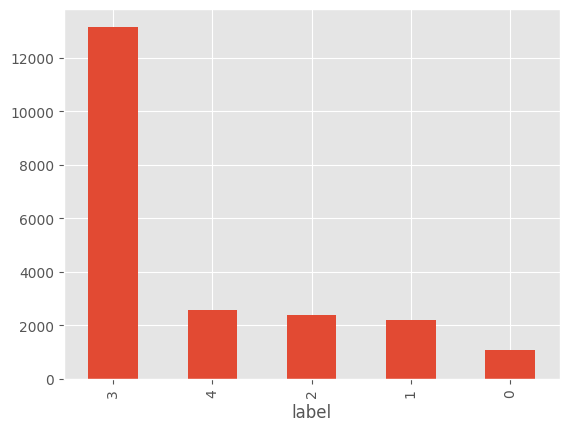

In [179]:
df.label.value_counts().plot(kind="bar")

In [180]:
# train과 test를 9:1로 나눠주세요.
# random_state은 자유롭게 지정 가능합니다.
train_df, valid_df = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.label.values
)

In [181]:
class CassavaDataset(torch.utils.data.Dataset):

    def __init__(self, df, data_path=DATA_PATH, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "train_images" if mode == "train" else "test_images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label

In [182]:
#데이터 증강
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [183]:
#사용 가능한 ViT 모델 목록
##우리는 이중 vit_base_patch16_224를 사용합니다!
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

Available Vision Transformer Models: 


['vit_7b_patch16_dinov3',
 'vit_base_mci_224',
 'vit_base_patch8_224',
 'vit_base_patch14_dinov2',
 'vit_base_patch14_reg4_dinov2',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_clip_quickgelu_224',
 'vit_base_patch16_dinov3',
 'vit_base_patch16_dinov3_qkvb',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_plus_clip_240',
 'vit_base_patch16_reg4_gap_256',
 'vit_base_patch16_rope_224',
 'vit_base_patch16_rope_ape_224',
 'vit_base_patch16_rope_mixed_224',
 'vit_base_patch16_rope_mixed_ape_224',
 'vit_base_patch16_rope_reg1_gap_256',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_siglip_224',
 'vit_base_patch16_siglip_256',
 'vit_base_patch16_siglip_384',
 'vit_base_patch16_siglip_512',
 'vit_base_patch16_siglip_gap_224',
 'vit_base_patch16_siglip_gap_256',
 'vit_base_patch16_siglip_gap_384',
 'vit_base_patch16_siglip

### 모델 설계
- 클래스 ViTBase16의 각 줄을 설명하는 주석을 달아주세요. (최소 15개)

In [193]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):
        # nn.Module 초기화: 부모 클래스의 생성자를 호출하여 내부 시스템(등록된 파라미터 등)을 준비
        super(ViTBase16, self).__init__()

        # timm 라이브러리로 ViT-Base (patch size 16, 224 입력) 모델을 생성 (기본은 임베딩/블록 등 백본 포함)
        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        # pretrained=True로 들어오면 사용자 정의 경로의 가중치를 불러와서 모델에 로드
        if pretrained:
            self.model.load_state_dict(torch.load(MODEL_PATH))

        # 분류 헤드 교체: 기존 head의 입력 차원(in_features)은 유지하고, 출력 차원을 n_classes로 변경
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        # 순전파 정의: timm 모델에 입력 x를 전달하여 로짓(미분류 점수)을 얻음
        x = self.model(x)
        # 최종 출력 반환 (손실 함수/소프트맥스는 바깥에서 적용)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # 한 에폭 동안의 평균 손실과 정확도를 누적할 변수 초기화
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        # 학습 모드로 전환: 드롭아웃/배치정규화 등 학습 동작 활성화
        self.model.train()
        # 배치 반복: i는 배치 인덱스, data는 입력 이미지, target은 정답 라벨
        for i, (data, target) in enumerate(train_loader):
            # CUDA 환경이면 텐서를 GPU로 이동 (dtype은 DataLoader/Transform에서 이미 맞춰졌다고 가정)
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            # TPU(XLA) 환경이면 XLA 디바이스로 이동하며 dtype을 명시 (float32/long)
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # 이전 스텝의 그래디언트 초기화
            optimizer.zero_grad()
            # 모델 순전파로 로짓 계산
            output = self.forward(data)
            # 손실 계산(예: CrossEntropyLoss), output은 [B, n_classes], target은 [B]
            loss = criterion(output, target)
            # 역전파로 그래디언트 계산
            loss.backward()
            # 배치 정확도 계산: 예측 클래스(argmax)와 타깃 일치 비율
            accuracy = (output.argmax(dim=1) == target).float().mean()

            # 에폭 누적량 갱신(텐서 상태로 누적; 마지막에 배치 수로 평균)
            epoch_loss += loss
            epoch_accuracy += accuracy

            # TPU(XLA)에서는 일반 optimizer.step 대신 xm.optimizer_step을 호출해야 실제 업데이트가 적용됨
            if device.type == "xla":
                xm.optimizer_step(optimizer)

                # 마스터 프로세스에서만 간단한 진행 로그를 20배치마다 출력
                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                # CUDA/CPU 환경: 일반적인 옵티마이저 스텝
                optimizer.step()

        # 에폭 평균 손실과 평균 정확도를 반환 (배치 수로 나눔)
        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # 검증 손실과 정확도 누적 변수 초기화
        valid_loss = 0.0
        valid_accuracy = 0.0

        # 평가 모드로 전환: 드롭아웃/배치정규화가 평가 동작(고정 통계)으로 바뀜
        self.model.eval()
        # 검증 데이터 배치 반복
        for data, target in valid_loader:
            # CUDA면 GPU로 이동
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            # XLA면 XLA 디바이스로 이동 (dtype 명시)
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # 검증에서는 학습/그래디언트 계산 비활성화로 메모리/속도 최적화
            with torch.no_grad():
                # 순전파로 로짓 계산
                output = self.model(data)
                # 손실 및 정확도 계산
                loss = criterion(output, target)
                accuracy = (output.argmax(dim=1) == target).float().mean()

                # 누적
                valid_loss += loss
                valid_accuracy += accuracy

        # 배치 평균 손실과 정확도 반환
        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)


In [194]:
def fit_tpu(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):
    # 최적의 검증 손실을 무한대로 초기화하여 이후 더 작은 값이 나타나면 갱신
    valid_loss_min = np.inf

    # 에폭별 기록을 저장할 리스트들 (손실/정확도: 학습/검증)
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    # 1부터 epochs까지 반복하면서 학습 루프 수행
    for epoch in range(1, epochs + 1):
        # 파이썬 가비지 컬렉션 강제 호출로 메모리 파편화/누수를 완화
        gc.collect()
        # TPU(XLA) 전용 병렬 로더: DataLoader를 XLA 디바이스용 per-device 로더로 변환
        para_train_loader = pl.ParallelLoader(train_loader, [device])

        # TPU 멀티 프로세스 환경에서 "마스터" 프로세스만 로그를 출력
        xm.master_print(f"{'='*50}")
        xm.master_print(f"EPOCH {epoch} - TRAINING...")
        # 한 에폭 학습 수행: 모델 내부의 train_one_epoch가 실제 학습/역전파/옵티마이저 스텝 담당
        train_loss, train_acc = model.train_one_epoch(
            para_train_loader.per_device_loader(device), criterion, optimizer, device
        )
        # 현재 에폭의 학습 손실/정확도 로그 출력
        xm.master_print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        # 기록 리스트에 에폭 결과를 저장 (이때 텐서일 수 있으므로 그대로 보관)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # 학습 직후 불필요 객체 수거 시도 (메모리 안정화 목적)
        gc.collect()

        # 검증 데이터로 평가를 수행할지 여부 확인 (None이면 스킵)
        if valid_loader is not None:
            # 검증 전에도 가비지 컬렉션 호출
            gc.collect()
            # 검증용 ParallelLoader 생성 (TPU/XLA 환경에서 안전한 평가를 위해 필요)
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            xm.master_print(f"EPOCH {epoch} - VALIDATING...")
            # 한 에폭 검증 수행: 역전파 없이 손실/정확도 측정
            valid_loss, valid_acc = model.validate_one_epoch(
                para_valid_loader.per_device_loader(device), criterion, device
            )
            # 검증 결과 로그 출력
            xm.master_print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            # 기록 리스트에 검증 결과 누적
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            # 이전까지의 최소 검증 손실보다 낮으면(성능 향상) 체크포인트 저장 알림
            # (epoch != 1 조건은 첫 에폭에서의 형식적 메시지 출력을 방지하기 위함)
            if valid_loss <= valid_loss_min and epoch != 1:
                xm.master_print(
                    "Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...".format(
                        valid_loss_min, valid_loss
                    )
                )

            # 최소 검증 손실 갱신(다음 에폭 비교를 위해 최신값 보관)
            valid_loss_min = valid_loss

    # 최종적으로 학습 과정에서 수집한 지표들을 딕셔너리 형태로 반환
    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

In [195]:
model = ViTBase16(n_classes=5, pretrained=True)

In [196]:
# --- torch_xla world_size/rank 호환 유틸 ---
try:
    import torch_xla.runtime as xr  # PJRT (신 API)
    def _world_size(): return xr.world_size()
    def _rank(): return xr.global_ordinal()
except Exception:
    import torch_xla.core.xla_model as xm  # 구/중간 API
    def _world_size():
        # xla_world_size가 있으면 우선 사용, 없으면 xrt_world_size로 폴백
        return getattr(xm, "xla_world_size", getattr(xm, "xrt_world_size"))()
    def _rank(): return xm.get_ordinal()

def _run():
    # NOTE: 실제로 검증셋이 따로 있으면 아래 valid_dataset에서 train_df 대신 valid_df를 사용하세요.
    train_dataset = CassavaDataset(train_df, transforms=transforms_train)
    valid_dataset = CassavaDataset(train_df, transforms=transforms_valid)  # <- valid_df 있으면 교체

    world_size = _world_size()
    rank = _rank()

    # world_size가 1이면 DistributedSampler를 생략하고 DataLoader의 shuffle을 사용
    if world_size > 1:
        train_sampler = torch.utils.data.distributed.DistributedSampler(
            train_dataset,
            num_replicas=world_size,
            rank=rank,
            shuffle=True,
        )
        valid_sampler = torch.utils.data.distributed.DistributedSampler(
            valid_dataset,
            num_replicas=world_size,
            rank=rank,
            shuffle=False,
        )
        train_sampler_arg = train_sampler
        valid_sampler_arg = valid_sampler
        train_shuffle = False
    else:
        train_sampler_arg = None
        valid_sampler_arg = None
        train_shuffle = True  # 단일 프로세스면 DataLoader의 shuffle 사용

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler_arg,
        shuffle=train_shuffle,
        drop_last=True,
        num_workers=8,
    )

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_sampler_arg,
        shuffle=False,
        drop_last=True,
        num_workers=8,
    )

    criterion = nn.CrossEntropyLoss()  # cross entropy loss
    device = xm.xla_device()
    model.to(device)

    # 글로벌 배치 스케일링을 가정한 학습률 조정 (필요 없으면 LR 그대로 쓰세요)
    lr = LR * world_size
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xm.master_print(f"INITIALIZING TRAINING ON {world_size} TPU CORES")
    start_time = datetime.now()
    xm.master_print(f"Start Time: {start_time}")

    logs = fit_tpu(
        model=model,
        epochs=N_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

    xm.master_print(f"Execution time: {datetime.now() - start_time}")

    xm.master_print("Saving Model")
    xm.save(
        model.state_dict(), f'model_5e_{datetime.now().strftime("%Y%m%d-%H%M")}.pth'
    )


In [199]:
# Training 시작
def _mp_fn(rank, flags):
    torch.set_default_tensor_type("torch.FloatTensor")
    a = _run()


# Run
FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=1, start_method="fork")

/tmp/ipython-input-1838953060.py:62: DeprecationWarning: Use torch_xla.device instead
  device = xm.xla_device()


INITIALIZING TRAINING ON 1 TPU CORES
Start Time: 2025-11-06 05:05:08.597332
EPOCH 1 - TRAINING...
	BATCH 1/340 - LOSS: 2.015625
	BATCH 21/340 - LOSS: 1.8515625
	BATCH 41/340 - LOSS: 1.5546875
	BATCH 61/340 - LOSS: 1.2734375
	BATCH 81/340 - LOSS: 1.3828125
	BATCH 101/340 - LOSS: 0.99609375
	BATCH 121/340 - LOSS: 1.15625
	BATCH 141/340 - LOSS: 1.2578125
	BATCH 161/340 - LOSS: 0.94921875
	BATCH 181/340 - LOSS: 1.171875
	BATCH 201/340 - LOSS: 1.0078125
	BATCH 221/340 - LOSS: 0.734375
	BATCH 241/340 - LOSS: 1.2265625
	BATCH 261/340 - LOSS: 1.015625
	BATCH 281/340 - LOSS: 0.98046875
	BATCH 301/340 - LOSS: 0.93359375
	BATCH 321/340 - LOSS: 1.1171875

	[TRAIN] EPOCH 1 - LOSS: 1.1328125, ACCURACY: 0.61328125

EPOCH 1 - VALIDATING...
	[VALID] LOSS: 0.9921875, ACCURACY: 0.67578125

Execution time: 0:01:18.276088
Saving Model
